# Lab ML for Data Science: Part III
## Getting Insights into Images and their Metadata (Plant Disease Data Set)

by Niklas Klein, Nicolas Junghanns, Weihang Li

**Mount to Google Drive:**

In [1]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


**Imports:**

In [2]:
import torch
import random
import torchvision
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import copy
import matplotlib.pyplot as plt

**Data Preprocessing / Preparations:**


In this part the data is loaded, the images are transformed according in preparation for the VGG-16 model, a Dataset class is created and the data is split into a train and test dataset.

In [3]:
# Directory path
data_dir = '/content/drive/MyDrive/Plant_leave_diseases_dataset_with_augmentation'

# Image Transformations
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Custom Dataset Class
class PlantDiseaseDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

def get_image_paths_and_labels(data_dir, class_names, samples_per_class):
    data = []
    for class_name in class_names:
        class_dir = os.path.join(data_dir, class_name)
        img_names = os.listdir(class_dir)
        random.shuffle(img_names)  # Shuffle the images
        for img_name in img_names[:samples_per_class]:  # Take the first N shuffled images
            img_path = os.path.join(class_dir, img_name)
            label = class_names.index(class_name)
            data.append((img_path, label))
    return data

# Set the number of samples per class
samples_per_class = 600

# Class names
class_names = ['Apple___healthy', 'Apple___Black_rot']

# Getting image paths and labels
data = get_image_paths_and_labels(data_dir, class_names, samples_per_class)

# Split the data into train and test sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Create Datasets
train_dataset = PlantDiseaseDataset(train_data, transform)
test_dataset = PlantDiseaseDataset(test_data, transform)

**Define model and biased model:**


Now we build the model as the combination of the pretrained VGG-16 feature extractor and our overlaying difference of means *(w)*. We then also create the modified biased model *(part 4.2 of the inital task)* and replace the convolutional and linear layers with our costumized biased layers, which we also define here.

In [4]:
# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Load the pre-trained VGG16 model
model = models.vgg16(pretrained=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)


# Compute difference of means on extracted features of the pretrained VGG16
def compute_model(model, train_loader):
    model.eval()

    # Initialize two lists to store features and labels
    features = []
    labels = []

    # Iterate over data.
    for inputs, labels_ in train_loader:
        inputs = inputs.to(device)

        with torch.no_grad():
            output = model.features(inputs)

        # Append features and labels to our lists
        features.append(output.reshape(output.size(0), -1).detach().cpu())
        labels.append(labels_)

    # Convert lists to tensors
    features_t = torch.cat(features, dim=0)
    labels_t = torch.cat(labels, dim=0)

    # Compute mean feature vector for each class
    mu_1 = torch.mean(features_t[labels_t == 0], dim=0)
    mu_2 = torch.mean(features_t[labels_t == 1], dim=0)

    # Compute direction of the difference of means
    w = (mu_2 - mu_1)
    w = w / torch.norm(w)

    return w, features, labels

# BiasedLayer class definition
class BiasedLayer(torch.nn.Module):
    def __init__(self, original_layer):
        super().__init__()
        self.original_layer = original_layer
        self.biased_layer = copy.deepcopy(original_layer)
        self.bias = 0.2 # Modify bias constant here
        # Add a bias to the weights and biases
        with torch.no_grad():
            self.biased_layer.weight.add_(self.bias * torch.clamp(self.biased_layer.weight, min=0))
            if self.biased_layer.bias is not None:
                self.biased_layer.bias.add_(self.bias * torch.clamp(self.biased_layer.bias, min=0))

    # Calculate zk
    def forward(self, x):
        z_orig = self.original_layer(x)
        z_bias = self.biased_layer(x)
        return z_bias * (z_orig / (z_bias + 1e-10)).detach()

# Create biased model
biased_model = copy.deepcopy(model)
for i, layer in enumerate(biased_model.features):
    if isinstance(layer, (torch.nn.Conv2d, torch.nn.Linear)) and i != 0 and i != len(biased_model.features) - 1:
        biased_model.features[i] = BiasedLayer(layer) # Replace all layers except first and last

biased_model = biased_model.to(device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:01<00:00, 416MB/s]


**Extract features and calculate difference of means for both models:**

In [5]:
w, features, labels = compute_model(model, train_loader)

In [6]:
w_biased, features_biased, labels_biased = compute_model(biased_model, train_loader)

**Test models and compute scores and importances:**



The models are tested on a disjunct dataset to compute the test scores (*g(x)*) and the resulting AUC of the ROC curve. In the same step, we also calculate the pixelwise importances (*S_i*) for our sensitivity analysis.

In [7]:
# Test model function to compute test scores, AUC scores, importances and predicted labels
def test_model(model, test_loader, w, compute_importance=False):
    model.eval()
    w_device = w.to(device)

    test_scores = []
    importances = []
    predicted_labels = []
    true_labels = []

    correct = 0  # Counter for correct predictions
    total = 0  # Counter for total predictions

    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        total += labels.size(0)

        inputs.requires_grad = compute_importance

        output = model.features(inputs)
        output.backward(gradient=torch.ones_like(output))

        score = torch.matmul(w_device, output.reshape(output.size(0), -1).T)
        test_scores.extend(score.detach().cpu().numpy())

        if compute_importance:
            gradient = inputs.grad.squeeze().detach()
            importance = gradient.pow(2).mean(dim=0)
            importances.append(importance.cpu())

        test_sign = score.detach().cpu().numpy()
        test_pred = np.where(test_sign > 0, 1, 0)
        predicted_labels.extend(test_pred)

        true_labels.extend(labels.cpu().numpy())
        if (int(test_pred) == int(labels.cpu().numpy())):
          correct += 1

    # Compute AUC score
    auc_score = roc_auc_score(true_labels, test_scores)

    # Print out the number of correct predictions and accuracy
    print(f'Number of correct predictions: {correct} out of {total}')
    print(f'Accuracy: {correct / total * 100}%')

    return auc_score, test_scores, importances, predicted_labels

# Test both models and compute AUC Scores
auc_score, test_scores, importances, predicted_labels = test_model(model, test_loader, w, compute_importance=True)
auc_score_biased, test_scores_biased, importances_biased, predicted_labels_biased = test_model(biased_model, test_loader, w_biased, compute_importance=True)

# Count the number of instances for each class
test_true = np.array([label for _, label in test_data])
class_counts = np.bincount(test_true)

print(f'Class 0 (apple-healthy): {class_counts[0]} instances, Class 1 (apple-black-rot): {class_counts[1]} instances')
print('AUC score (model): {:.4f}'.format(auc_score))
print('AUC score (biased_model): {:.4f}'.format(auc_score_biased))

Number of correct predictions: 140 out of 240
Accuracy: 58.333333333333336%
Number of correct predictions: 140 out of 240
Accuracy: 58.333333333333336%
Class 0 (apple-healthy): 122 instances, Class 1 (apple-black-rot): 118 instances
AUC score (model): 0.9901
AUC score (biased_model): 0.9901


**Sensitivity analysis:**

Finally, we use these importance values to create heatmaps of some test images to visualize the defining features of the model classification.

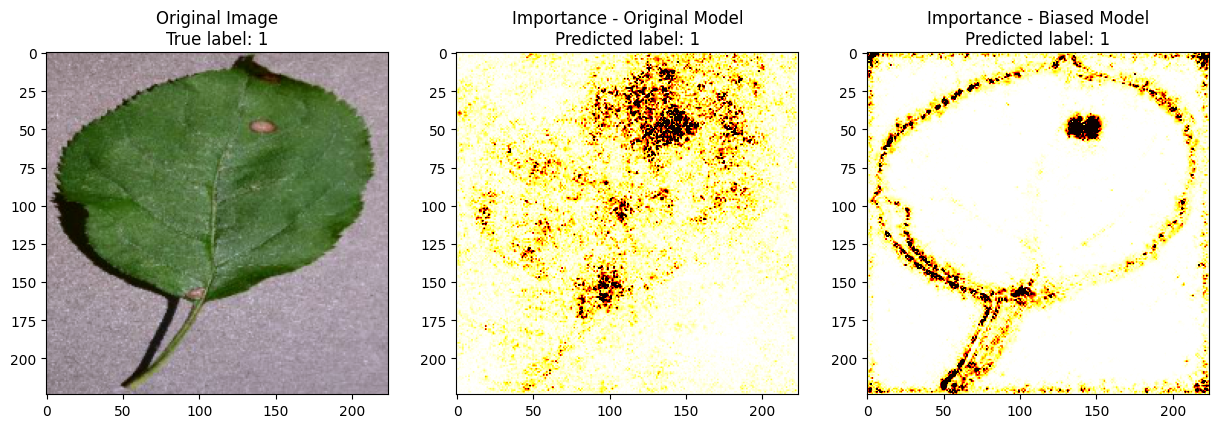

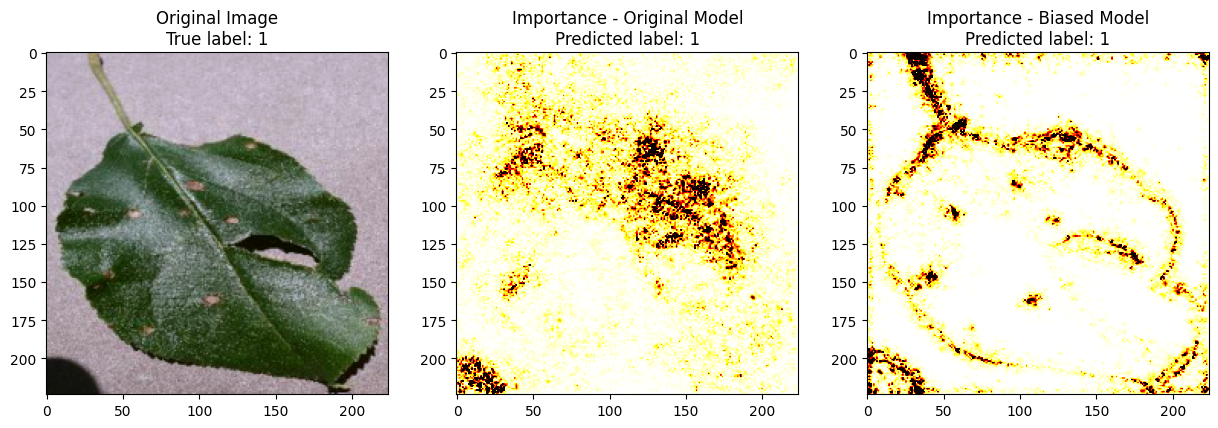

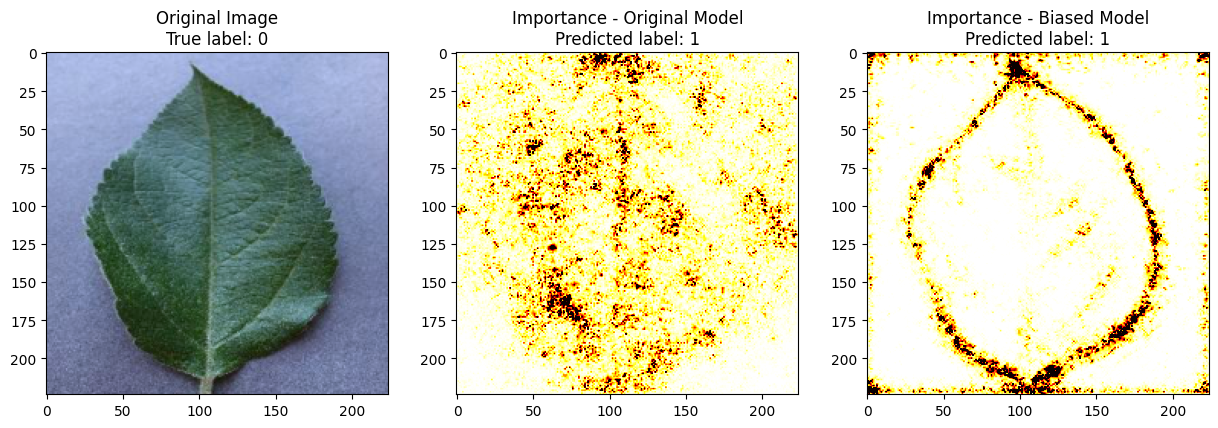

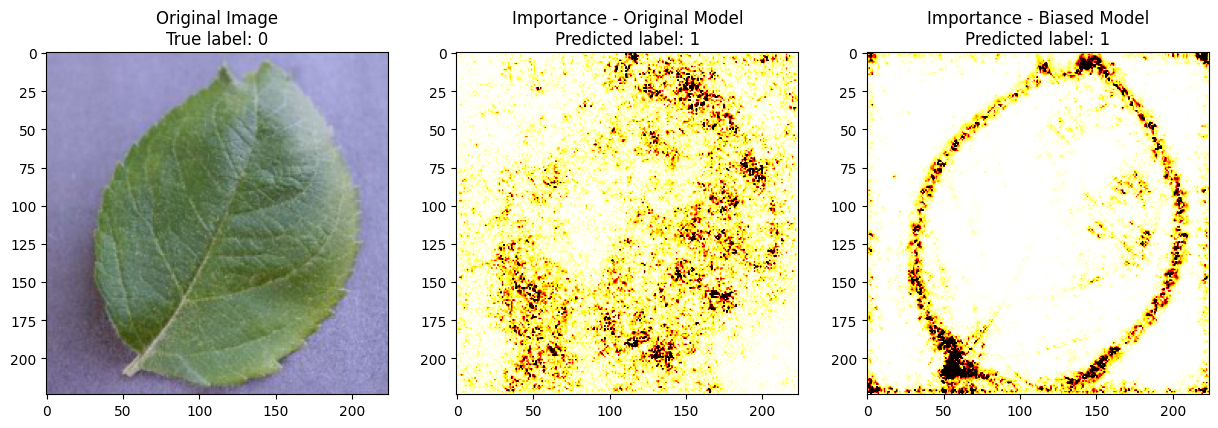

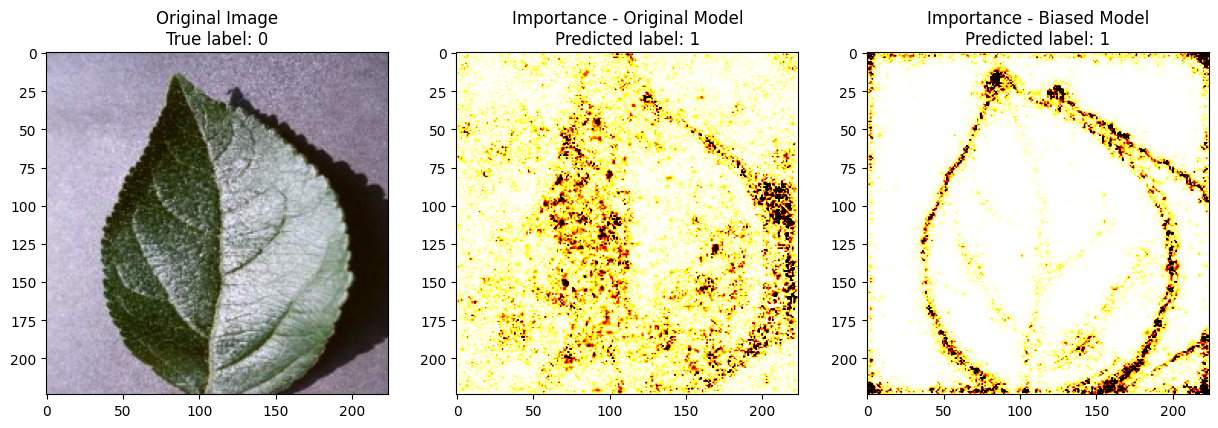

In [8]:
def plot_heatmaps(image, original_importance, biased_importance, true_label, predicted_label, predicted_label_biased):
    fig, ax = plt.subplots(1, 3, figsize=(15,5))

    # To undo the normalization we need to apply inverse transformation
    inv_normalize = transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
        std=[1/0.229, 1/0.224, 1/0.255]
    )

    image = inv_normalize(image)
    image = image.permute(1, 2, 0)
    image = np.clip(image, 0., 1.)  # values may be out of range due to numerical errors in denormalization

    # Plot original image
    ax[0].imshow(image)
    ax[0].title.set_text('Original Image\nTrue label: {}'.format(true_label))

    # Plot heatmap for original model
    ax[1].imshow(original_importance, cmap='hot_r', vmax=np.percentile(original_importance, 98))
    ax[1].title.set_text('Importance - Original Model\nPredicted label: {}'.format(predicted_label))

    # Plot heatmap for biased model
    ax[2].imshow(biased_importance, cmap='hot_r', vmax=np.percentile(biased_importance, 98))
    ax[2].title.set_text('Importance - Biased Model\nPredicted label: {}'.format(predicted_label_biased))

    plt.show()

# Plot heatmaps for the first few images in the test set
for i in range(5):
    true_label = test_dataset[i][1]
    plot_heatmaps(test_dataset[i][0], importances[i], importances_biased[i], true_label, predicted_labels[i], predicted_labels_biased[i])



**4.3 Discussion / Conclusion**

Feature extraction: Difference of means' performance heavily depends on the quality of the features. If the features do not separate the classes well, the method will perform poorly. In this project, features are extracted using a pre-trained VGG-16 model. But these features are more generic and not necessarily suitable to the task of identifying specific plant diseases. It might be beneficial to experiment with other methods of feature extraction, or to fine-tune the pre-trained model on the specific task of disease identification.

Flawed understanding of the plant disease: If the disease markers are not well understood, the model might highlight irrelevant areas that could be misleading. Consulting with domain experts or augmenting the dataset with more specific or specialized labels might help in this scenario.

In our biased model's heatmaps you can clearly identify the dotted disease patterns/structures on the leafs if they appear, but the exctracted features seem to basically outline any borders of any consistent picture areas. Therefore we further suggest to train the feature extraction of the biased model with the actual dataset to better fit the classifier to the samples. This way one could quickly adjust the network's weights to allow for more precise classification.